In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [4]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [5]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [6]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [7]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [8]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
def build_1d_cnn_custom_ch_128_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=128, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=128*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [10]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_128_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.3955 - acc: 0.2366
Epoch 00001: val_loss improved from inf to 2.28923, saving model to model/checkpoint/1D_CNN_1_conv_custom_DO_BN_checkpoint/001-2.2892.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 3.3952 - acc: 0.2367 - val_loss: 2.2892 - val_acc: 0.2954
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5224 - acc: 0.5422
Epoch 00002: val_loss did not improve from 2.28923
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.5225 - acc: 0.5422 - val_loss: 2.4981 - val_acc: 0.3208
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0780 - acc: 0.6749
Epoch 00003: val_loss did not improve from 2.28923
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.0780 - acc: 0.6749 - val_loss: 2.8146 - val_ac

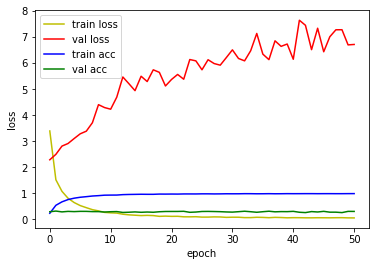

4815/4815 [==============================] - 2s 439us/sample - loss: 2.3072 - acc: 0.2771
Loss: 2.3071924338335807 Accuracy: 0.27705088

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0567 - acc: 0.2694
Epoch 00001: val_loss improved from inf to 2.96232, saving model to model/checkpoint/1D_CNN_2_conv_custom_DO_BN_checkpoint/001-2.9623.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 3.0567 - acc: 0.2694 - val_loss: 2.9623 - val_acc: 0.2604
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9926 - acc: 0.4381
Epoch 00002: val_loss improved from 2.96232 to 2.55095, saving model to model/checkpoint/1D_CNN_2_conv_custom_DO_BN_checkpoint/002-2.5510.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 1.9926 - acc: 0.4381 - val_loss: 2.5510 - val_acc: 0.3373
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5743 - 

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9664
Epoch 00030: val_loss did not improve from 2.55095
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.1245 - acc: 0.9664 - val_loss: 4.6039 - val_acc: 0.4279
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1260 - acc: 0.9650
Epoch 00031: val_loss did not improve from 2.55095
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.1260 - acc: 0.9650 - val_loss: 5.5145 - val_acc: 0.3769
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1170 - acc: 0.9682
Epoch 00032: val_loss did not improve from 2.55095
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.1171 - acc: 0.9682 - val_loss: 4.8877 - val_acc: 0.4191
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1096 - acc: 0.9705
Epoch 00033: val_loss did not improve from 2.55095
36805/36805 [===========

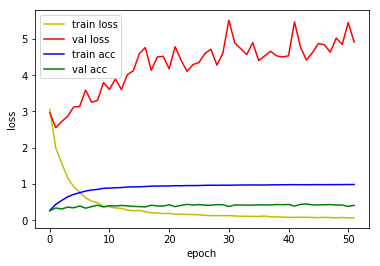

4815/4815 [==============================] - 3s 727us/sample - loss: 2.6599 - acc: 0.3225
Loss: 2.6599495181165875 Accuracy: 0.32253376

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3728 - acc: 0.3373
Epoch 00001: val_loss improved from inf to 2.30419, saving model to model/checkpoint/1D_CNN_3_conv_custom_DO_BN_checkpoint/001-2.3042.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 2.3726 - acc: 0.3373 - val_loss: 2.3042 - val_acc: 0.3079
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6096 - acc: 0.5194
Epoch 00002: val_loss improved from 2.30419 to 1.81237, saving model to model/checkpoint/1D_CNN_3_conv_custom_DO_BN_checkpoint/002-1.8124.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.6101 - acc: 0.5194 - val_loss: 1.8124 - val_acc: 0.4619
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3035 - 

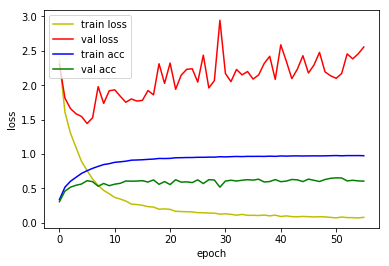

4815/4815 [==============================] - 4s 852us/sample - loss: 1.5859 - acc: 0.5691
Loss: 1.5858958748394578 Accuracy: 0.569055

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1467 - acc: 0.3592
Epoch 00001: val_loss improved from inf to 1.55041, saving model to model/checkpoint/1D_CNN_4_conv_custom_DO_BN_checkpoint/001-1.5504.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 2.1466 - acc: 0.3592 - val_loss: 1.5504 - val_acc: 0.5013
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4399 - acc: 0.5561
Epoch 00002: val_loss improved from 1.55041 to 1.19985, saving model to model/checkpoint/1D_CNN_4_conv_custom_DO_BN_checkpoint/002-1.1998.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.4399 - acc: 0.5561 - val_loss: 1.1998 - val_acc: 0.6308
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2007 - ac

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2433 - acc: 0.9209
Epoch 00027: val_loss did not improve from 0.88517
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2433 - acc: 0.9209 - val_loss: 1.0767 - val_acc: 0.7354
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2377 - acc: 0.9237
Epoch 00028: val_loss did not improve from 0.88517
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2377 - acc: 0.9237 - val_loss: 1.0711 - val_acc: 0.7435
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2259 - acc: 0.9270
Epoch 00029: val_loss did not improve from 0.88517
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2259 - acc: 0.9270 - val_loss: 1.2333 - val_acc: 0.7100
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2262 - acc: 0.9267
Epoch 00030: val_loss did not improve from 0.88517
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1189 - acc: 0.9635
Epoch 00057: val_loss did not improve from 0.88517
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1188 - acc: 0.9635 - val_loss: 1.0483 - val_acc: 0.7815
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1165 - acc: 0.9633
Epoch 00058: val_loss did not improve from 0.88517
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1165 - acc: 0.9633 - val_loss: 1.1864 - val_acc: 0.7510
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1229 - acc: 0.9617
Epoch 00059: val_loss did not improve from 0.88517
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1229 - acc: 0.9617 - val_loss: 1.0331 - val_acc: 0.7820
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1121 - acc: 0.9655
Epoch 00060: val_loss did not improve from 0.88517
36805/36805 [===========

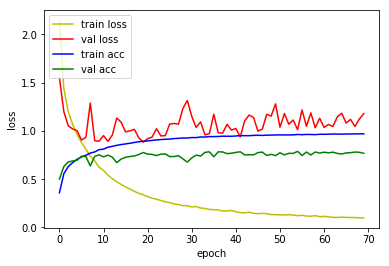

4815/4815 [==============================] - 4s 884us/sample - loss: 1.0541 - acc: 0.7173
Loss: 1.0541436347387043 Accuracy: 0.71734166

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0914 - acc: 0.3708
Epoch 00001: val_loss improved from inf to 1.51326, saving model to model/checkpoint/1D_CNN_5_conv_custom_DO_BN_checkpoint/001-1.5133.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 2.0914 - acc: 0.3708 - val_loss: 1.5133 - val_acc: 0.5222
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3343 - acc: 0.5870
Epoch 00002: val_loss improved from 1.51326 to 1.12484, saving model to model/checkpoint/1D_CNN_5_conv_custom_DO_BN_checkpoint/002-1.1248.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.3343 - acc: 0.5870 - val_loss: 1.1248 - val_acc: 0.6429
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1097 - 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2727 - acc: 0.9133
Epoch 00027: val_loss did not improve from 0.65226
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2727 - acc: 0.9133 - val_loss: 0.7267 - val_acc: 0.8143
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2630 - acc: 0.9153
Epoch 00028: val_loss did not improve from 0.65226
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2630 - acc: 0.9153 - val_loss: 0.7825 - val_acc: 0.8027
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2541 - acc: 0.9178
Epoch 00029: val_loss did not improve from 0.65226
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2542 - acc: 0.9178 - val_loss: 0.6719 - val_acc: 0.8251
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2398 - acc: 0.9215
Epoch 00030: val_loss did not improve from 0.65226
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1282 - acc: 0.9591
Epoch 00057: val_loss did not improve from 0.65226
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1282 - acc: 0.9591 - val_loss: 0.7618 - val_acc: 0.8339
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1253 - acc: 0.9605
Epoch 00058: val_loss did not improve from 0.65226
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1252 - acc: 0.9605 - val_loss: 0.7810 - val_acc: 0.8293
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1207 - acc: 0.9608
Epoch 00059: val_loss did not improve from 0.65226
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1207 - acc: 0.9608 - val_loss: 0.7975 - val_acc: 0.8206
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1184 - acc: 0.9625
Epoch 00060: val_loss did not improve from 0.65226
36805/36805 [===========

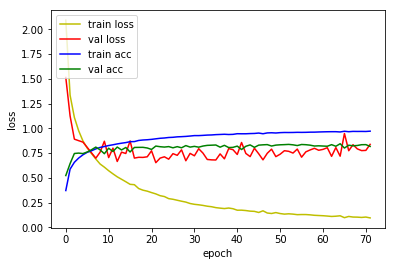

4815/4815 [==============================] - 5s 948us/sample - loss: 0.7541 - acc: 0.7807
Loss: 0.7540559037452175 Accuracy: 0.78068537

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2130 - acc: 0.3274
Epoch 00001: val_loss improved from inf to 1.51934, saving model to model/checkpoint/1D_CNN_6_conv_custom_DO_BN_checkpoint/001-1.5193.hdf5
36805/36805 [==============================] - 99s 3ms/sample - loss: 2.2129 - acc: 0.3275 - val_loss: 1.5193 - val_acc: 0.4964
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3525 - acc: 0.5717
Epoch 00002: val_loss improved from 1.51934 to 1.00728, saving model to model/checkpoint/1D_CNN_6_conv_custom_DO_BN_checkpoint/002-1.0073.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.3524 - acc: 0.5717 - val_loss: 1.0073 - val_acc: 0.6960
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0826 - 

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1209 - acc: 0.9611
Epoch 00054: val_loss did not improve from 0.37743
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1209 - acc: 0.9611 - val_loss: 0.4015 - val_acc: 0.8991
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1213 - acc: 0.9604
Epoch 00055: val_loss did not improve from 0.37743
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1212 - acc: 0.9604 - val_loss: 0.4612 - val_acc: 0.8919
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1136 - acc: 0.9634
Epoch 00056: val_loss did not improve from 0.37743
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1136 - acc: 0.9634 - val_loss: 0.3892 - val_acc: 0.8975
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1141 - acc: 0.9636
Epoch 00057: val_loss did not improve from 0.37743
36805/36805 [===========

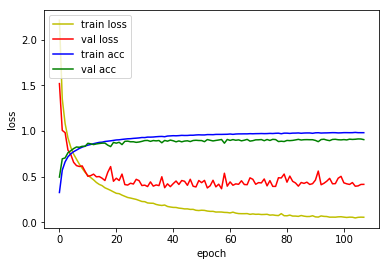

4815/4815 [==============================] - 5s 987us/sample - loss: 0.4597 - acc: 0.8827
Loss: 0.45965244111489906 Accuracy: 0.88265836

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2683 - acc: 0.3092
Epoch 00001: val_loss improved from inf to 1.47777, saving model to model/checkpoint/1D_CNN_7_conv_custom_DO_BN_checkpoint/001-1.4778.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 2.2682 - acc: 0.3092 - val_loss: 1.4778 - val_acc: 0.5386
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3631 - acc: 0.5650
Epoch 00002: val_loss improved from 1.47777 to 0.98671, saving model to model/checkpoint/1D_CNN_7_conv_custom_DO_BN_checkpoint/002-0.9867.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.3631 - acc: 0.5651 - val_loss: 0.9867 - val_acc: 0.6869
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0193 

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0751 - acc: 0.9757
Epoch 00054: val_loss did not improve from 0.20305
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0751 - acc: 0.9757 - val_loss: 0.2438 - val_acc: 0.9408
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0696 - acc: 0.9780
Epoch 00055: val_loss did not improve from 0.20305
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0697 - acc: 0.9780 - val_loss: 0.2574 - val_acc: 0.9304
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0720 - acc: 0.9769
Epoch 00056: val_loss did not improve from 0.20305
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0721 - acc: 0.9769 - val_loss: 0.2430 - val_acc: 0.9401
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0809 - acc: 0.9736
Epoch 00057: val_loss did not improve from 0.20305
36805/36805 [===========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9868
Epoch 00084: val_loss did not improve from 0.20305
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0403 - acc: 0.9868 - val_loss: 0.2813 - val_acc: 0.9404
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0350 - acc: 0.9896
Epoch 00085: val_loss did not improve from 0.20305
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0350 - acc: 0.9896 - val_loss: 0.2928 - val_acc: 0.9373
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0477 - acc: 0.9844
Epoch 00086: val_loss did not improve from 0.20305
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0477 - acc: 0.9844 - val_loss: 0.2309 - val_acc: 0.9483
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9906
Epoch 00087: val_loss did not improve from 0.20305
36805/36805 [===========

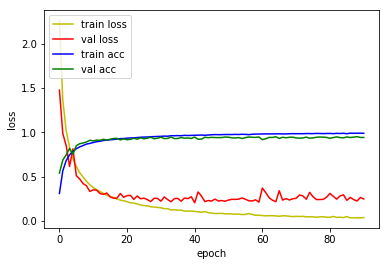

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2338 - acc: 0.9373
Loss: 0.23377935187281848 Accuracy: 0.93727934

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2547 - acc: 0.3224
Epoch 00001: val_loss improved from inf to 1.45089, saving model to model/checkpoint/1D_CNN_8_conv_custom_DO_BN_checkpoint/001-1.4509.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 2.2546 - acc: 0.3224 - val_loss: 1.4509 - val_acc: 0.5344
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2286 - acc: 0.6094
Epoch 00002: val_loss improved from 1.45089 to 0.74118, saving model to model/checkpoint/1D_CNN_8_conv_custom_DO_BN_checkpoint/002-0.7412.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 1.2287 - acc: 0.6094 - val_loss: 0.7412 - val_acc: 0.7857
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8554 - 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1007 - acc: 0.9678
Epoch 00026: val_loss did not improve from 0.15467
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1007 - acc: 0.9678 - val_loss: 0.1641 - val_acc: 0.9532
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0991 - acc: 0.9685
Epoch 00027: val_loss improved from 0.15467 to 0.14992, saving model to model/checkpoint/1D_CNN_8_conv_custom_DO_BN_checkpoint/027-0.1499.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0992 - acc: 0.9685 - val_loss: 0.1499 - val_acc: 0.9564
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0958 - acc: 0.9695
Epoch 00028: val_loss improved from 0.14992 to 0.14742, saving model to model/checkpoint/1D_CNN_8_conv_custom_DO_BN_checkpoint/028-0.1474.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0958 - acc: 0.9695 - val_loss: 0.1474 - val_

36800/36805 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9874
Epoch 00054: val_loss did not improve from 0.13223
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0400 - acc: 0.9874 - val_loss: 0.1337 - val_acc: 0.9623
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9875
Epoch 00055: val_loss did not improve from 0.13223
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0411 - acc: 0.9875 - val_loss: 0.1866 - val_acc: 0.9534
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9888
Epoch 00056: val_loss did not improve from 0.13223
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0382 - acc: 0.9888 - val_loss: 0.1638 - val_acc: 0.9599
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0350 - acc: 0.9897
Epoch 00057: val_loss did not improve from 0.13223
36805/36805 [========================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9933
Epoch 00084: val_loss did not improve from 0.12621
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0226 - acc: 0.9933 - val_loss: 0.1736 - val_acc: 0.9592
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9912
Epoch 00085: val_loss did not improve from 0.12621
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0280 - acc: 0.9912 - val_loss: 0.1801 - val_acc: 0.9602
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0163 - acc: 0.9955
Epoch 00086: val_loss did not improve from 0.12621
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0165 - acc: 0.9954 - val_loss: 0.1420 - val_acc: 0.9660
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9934
Epoch 00087: val_loss did not improve from 0.12621
36805/36805 [===========

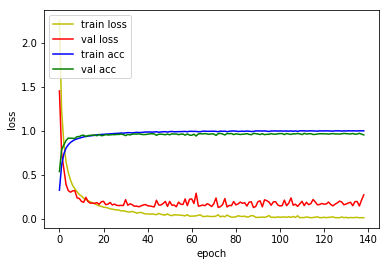

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1842 - acc: 0.9553
Loss: 0.1841527407607383 Accuracy: 0.9553479

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8299 - acc: 0.4602
Epoch 00001: val_loss improved from inf to 0.95912, saving model to model/checkpoint/1D_CNN_9_conv_custom_DO_BN_checkpoint/001-0.9591.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 1.8298 - acc: 0.4603 - val_loss: 0.9591 - val_acc: 0.7275
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7763 - acc: 0.7567
Epoch 00002: val_loss improved from 0.95912 to 0.41526, saving model to model/checkpoint/1D_CNN_9_conv_custom_DO_BN_checkpoint/002-0.4153.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.7763 - acc: 0.7567 - val_loss: 0.4153 - val_acc: 0.8821
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5221 - ac

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9845
Epoch 00026: val_loss did not improve from 0.12496
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0510 - acc: 0.9845 - val_loss: 0.1415 - val_acc: 0.9618
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9843
Epoch 00027: val_loss did not improve from 0.12496
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0499 - acc: 0.9843 - val_loss: 0.1334 - val_acc: 0.9606
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9864
Epoch 00028: val_loss did not improve from 0.12496
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0450 - acc: 0.9863 - val_loss: 0.1381 - val_acc: 0.9604
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0477 - acc: 0.9850
Epoch 00029: val_loss did not improve from 0.12496
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.9956
Epoch 00056: val_loss did not improve from 0.12496
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0162 - acc: 0.9956 - val_loss: 0.1676 - val_acc: 0.9620
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9947
Epoch 00057: val_loss did not improve from 0.12496
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0173 - acc: 0.9947 - val_loss: 0.2065 - val_acc: 0.9541
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9929
Epoch 00058: val_loss did not improve from 0.12496
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0225 - acc: 0.9929 - val_loss: 0.1499 - val_acc: 0.9632
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0139 - acc: 0.9957
Epoch 00059: val_loss did not improve from 0.12496
36805/36805 [===========

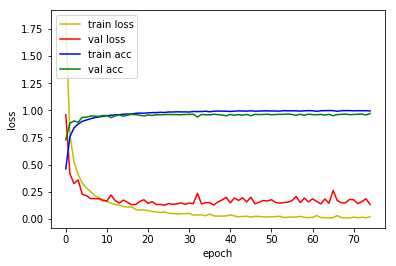

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1864 - acc: 0.9470
Loss: 0.18635888525042082 Accuracy: 0.9470405



In [11]:
for i in range(3, 10):
    model_name = '1D_CNN_custom_ch_128_DO_BN_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_128_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
for i in range(3, 10):
    model_name = '1D_CNN_custom_ch_128_DO_BN_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
____________________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.0541 - acc: 0.7173
Loss: 1.0541436347387043 Accuracy: 0.71734166

1D_CNN_5_conv_custom_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_56 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (None, 1600

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2338 - acc: 0.9373
Loss: 0.23377935187281848 Accuracy: 0.93727934

1D_CNN_8_conv_custom_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_74 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (None, 160

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1864 - acc: 0.9470
Loss: 0.18635888525042082 Accuracy: 0.9470405
